# **Pipeline de Dados Telegram - Gastos Pessoais**

## **1.Motivação do Projeto**

Vivemos em um mundo onde dados são gerados a todo momento. Mas como transformar essas informações em insights valiosos?

Imagine que você quer monitorar seus gastos automaticamente, sem precisar inserir manualmente cada transação em uma planilha.

Foi com essa ideia que nasceu este projeto: um **pipeline de dados do Telegram**, onde um chatbot captura mensagens contendo despesas, armazena os dados, processa e os disponibiliza para análise.

## **2. Contexto**

### **Chatbots e a Geração de Dados**

Os chatbots estão cada vez mais presentes no nosso dia a dia, facilitando interações e automatizando tarefas. O Telegram, por exemplo, permite a criação de bots que capturam mensagens enviadas pelos usuários e as disponibilizam via API.

### **Dados Transacionais vs. Dados Analíticos**

- **Dados transacionais**: Registram eventos individuais no dia a dia de uma empresa ou usuário (como uma compra).
- **Dados analíticos**: São estruturados e processados para gerar insights e auxiliar na tomada de decisões.

Nosso projeto parte de dados transacionais capturados no Telegram e os transforma em um conjunto de dados analíticos para análise de gastos pessoais.

## **3. Arquitetura do Sistema**

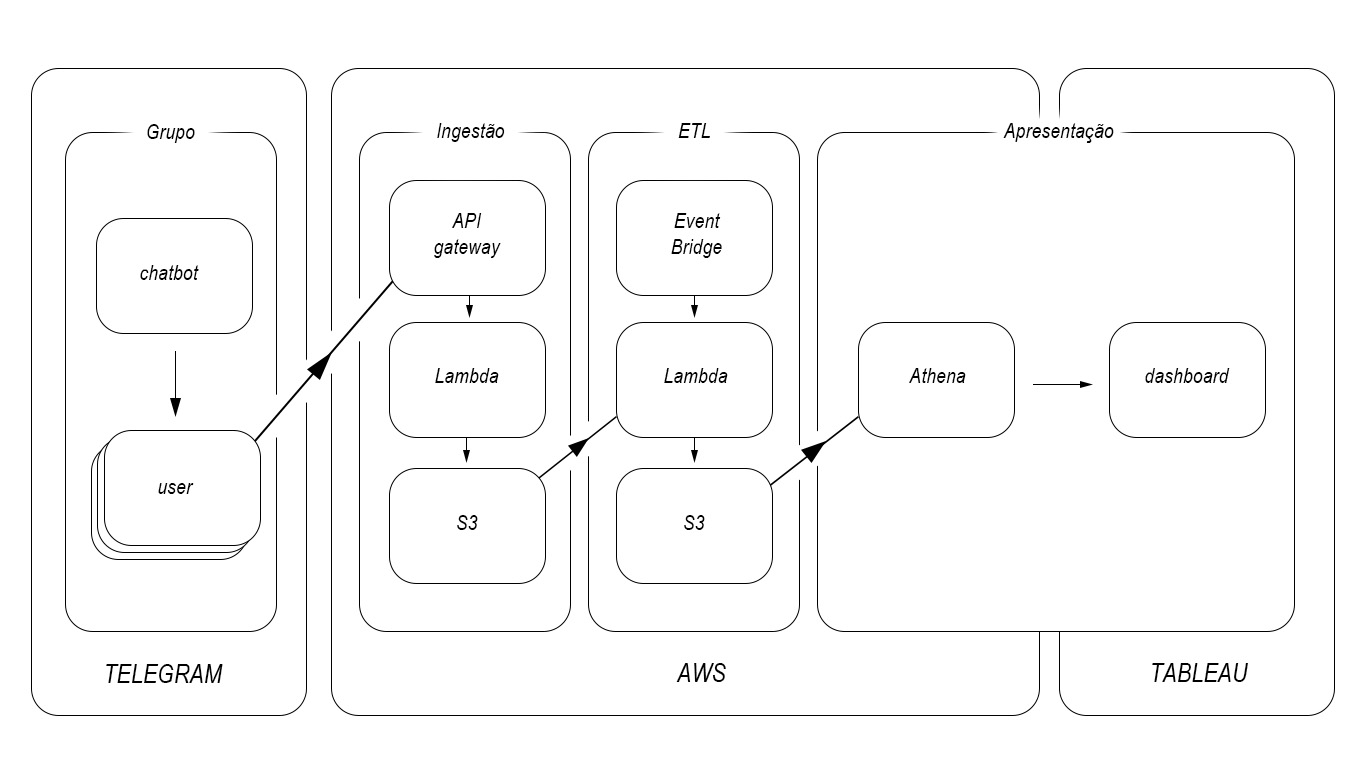





### **3.1. Sistema Transacional: Captura de Dados do Telegram**

- Um bot no Telegram recebe mensagens estruturadas no formato:
  ```
  Descrição, Valor, Data, Categoria, Método de Pagamento, Banco
  ```
- Essas mensagens são coletadas usando a API do Telegram.

### **3.2. Pipeline Analítico: Ingestão, ETL e Apresentação**

**Ingestão:**

Para capturar as mensagens enviadas ao bot do Telegram em tempo real, utilizamos um Webhook com O AWS API Gateway:

- O Telegram envia automaticamente as mensagens recebidas pelo bot para uma URL definida (Webhook).

- O Amazon API Gateway é responsável por expor a URL do Webhook de forma segura e escalável. Ele atua como um intermediário entre o Telegram e a AWS, permitindo o recebimento de mensagens em tempo real.
- Quando o bot recebe uma nova mensagem, o Telegram envia automaticamente os dados para o Webhook configurado.
- O API Gateway recebe essa solicitação e a encaminha para uma função AWS Lambda, que processa a requisição, extrai os dados da mensagem e os armazena no Amazon S3 no formato JSON. A função Lambda é a seguinte:




In [ ]:
import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3

def lambda_handler(event: dict, context: dict) -> dict:
    '''
    Recebe uma mensagem do Telegram via AWS API Gateway, verifica no
    seu conteúdo se foi produzida em um determinado grupo e a escreve,
    em seu formato original JSON, em um bucket do AWS S3.
    '''

    # Variáveis de ambiente
    BUCKET = os.environ['BUCKET_NAME']
    TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_GROUP_ID'])

    # Variáveis lógicas (Data e hora)
    tzinfo = timezone(offset=timedelta(hours=-3))  # Definindo o fuso horário
    date = datetime.now(tzinfo).strftime('%Y-%m-%d')  # Data formatada
    timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')  # Timestamp único

    filename = f'{timestamp}.json'

    # Cliente boto3 para S3
    client = boto3.client('s3')

    try:
        # Carrega o corpo da requisição
        message = json.loads(event["body"])  # Carrega o conteúdo do evento no formato JSON
        chat_id = message["message"]["chat"]["id"]  # Extrai o ID do chat da mensagem

        # Verifica se o ID do chat é o esperado
        if chat_id == TELEGRAM_CHAT_ID:
            # Cria um arquivo temporário para armazenar a mensagem
            with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
                json.dump(message, fp)  # Escreve a mensagem JSON no arquivo

            # Faz o upload do arquivo para o bucket S3
            client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

    except Exception as exc:
        # Se houver erro, loga o erro e retorna status 500
        logging.error(msg=exc)
        return {
            'statusCode': 500,
            'body': json.dumps({'error': str(exc)})
        }

    # Se tudo ocorrer bem, retorna status 200
    return {
        'statusCode': 200,
        'body': json.dumps({'message': 'Mensagem processada com sucesso!'})
    }


Esse modelo permite a ingestão automática e em tempo real das transações enviadas ao bot.

- O AWS Lambda captura os dados do bot e armazena os arquivos brutos (JSON) no Amazon S3.

**ETL (Extração, Transformação e Carga):**

- Um segundo AWS Lambda processa os dados, limpando inconsistências e convertendo o formato JSON para Parquet.



In [ ]:
import json
import boto3
import os
import pyarrow.parquet as pq
import pyarrow as pa
import re
from datetime import datetime, timedelta

s3 = boto3.client("s3")

RAW_BUCKET = os.environ["RAW_BUCKET"]
ENRICHED_BUCKET = os.environ["ENRICHED_BUCKET"]

# Expressão regular corrigida para capturar o valor decimal corretamente
message_pattern = re.compile(r"^\s*(.*?),\s*(\d+(?:\.\d{1,2})?)\s*,\s*(\d{2}/\d{2}/\d{4})\s*,\s*(.*?)\s*,\s*(.*?)\s*,\s*(.*?)\s*$")


def lambda_handler(event, context):
    try:
        yesterday = (datetime.utcnow() - timedelta(days=1)).strftime("%Y-%m-%d")
        print(f"Looking for files with date: {yesterday}")

        response = s3.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f"telegram/context_date={yesterday}/")

        if "Contents" not in response:
            return {"statusCode": 404, "body": "Nenhum arquivo encontrado"}

        data_list = []
        for obj in response["Contents"]:
            file_obj = s3.get_object(Bucket=RAW_BUCKET, Key=obj["Key"])
            file_data = json.loads(file_obj["Body"].read().decode("utf-8"))

            print(f"file_data: {file_data}")

            if isinstance(file_data, dict) and "message" in file_data:
                message = file_data["message"]

                # Tenta corrigir a codificação
                try:
                    message_text = message.get("text", "").encode("latin1").decode("utf-8")
                except UnicodeDecodeError:
                    message_text = message.get("text", "")  # Se falhar, usa o texto original

                match = message_pattern.match(message_text)
                if match:
                    print(f"Grupos extraídos: {match.groups()}")

                    if len(match.groups()) == 6:
                        description, value, date, category, method, bank = match.groups()

                        data_list.append({
                            "descricao": description,
                            "valor": float(value),
                            "data": datetime.strptime(date, "%d/%m/%Y").date(),
                            "categoria": category,
                            "metodo": method,
                            "banco": bank
                        })
                    else:
                        print(f"Erro na correspondência: {message_text} não tem 6 grupos.")

            else:
                print("O formato de file_data não é o esperado.")

        if not data_list:
            return {"statusCode": 404, "body": "Nenhuma mensagem válida encontrada"}

        # Converte os dados para uma tabela PyArrow
        table = pa.Table.from_pylist(data_list)

        # Define o nome do arquivo de saída
        output_file = f"processed/{yesterday}.parquet"

        # Salva a tabela no formato Parquet no diretório temporário
        pq.write_table(table, "/tmp/temp.parquet")

        # Carrega o arquivo Parquet no S3
        s3.upload_file("/tmp/temp.parquet", ENRICHED_BUCKET, output_file)

        return {"statusCode": 200, "body": "Processamento concluído"}

    except Exception as e:
        return {"statusCode": 500, "body": str(e)}


*Obs: para utilizar o pacote PyArrow foi necessário utilizar uma camada na função Lambda pois o pacote não está instalado no ambiente padrão do AWS Lambda*

- Os dados enriquecidos são armazenados em outro bucket no S3.

- Para garantir que os dados sejam processados de forma eficiente e automática, utilizamos o Amazon EventBridge, que utiliza uma regra diária para ler os arquivos salvos no S3 no dia anterior e aciona automaticamente a função Lambda de transformação de dados.

- O uso do EventBridge permite um fluxo de dados mais dinâmico e resiliente, garantindo que os arquivos sejam processados assim que forem recebidos no bucket RAW.

**Apresentação:**

- Utilização do AWS Athena para consultas SQL diretamente sobre os dados processados.Para isso, utilizamos o sequinte códido SQL para obter a tabela:

```sql
CREATE EXTERNAL TABLE gastos (
    descricao STRING,
    valor DOUBLE,
    data DATE,
    categoria STRING,
    metodo STRING,
    banco STRING
)
STORED AS PARQUET
LOCATION 's3://telegram-pipeline-davi-enriched/processed/'
TBLPROPERTIES ("parquet.compression"="SNAPPY");

```
- Criação de dashboard com o Tableau para visualização interativa e análise gráfica dos gastos a partir dos dados da tabela disponíveis no Athena.

## **4. Análise Exploratória de Dados**

### **4.1. Fonte: Analisando os Dados no Athena**

#### **Verificando a Qualidade dos Dados**
Valores ausentes em alguma coluna :
```sql
SELECT
    COUNT(*) AS total_registros,
    SUM(CASE WHEN descricao IS NULL THEN 1 ELSE 0 END) AS descricao_nula,
    SUM(CASE WHEN valor IS NULL THEN 1 ELSE 0 END) AS valor_nulo,
    SUM(CASE WHEN data IS NULL THEN 1 ELSE 0 END) AS data_nula,
    SUM(CASE WHEN categoria IS NULL THEN 1 ELSE 0 END) AS categoria_nulo,
    SUM(CASE WHEN metodo IS NULL THEN 1 ELSE 0 END) AS metodo_nulo,
    SUM(CASE WHEN banco IS NULL THEN 1 ELSE 0 END) AS banco_nulo
FROM gastos;
```
Resultado: sem valores nulos na tabela

![Valores Nulos](https://github.com/davicarv/Pipeline_Telegram/blob/main/Valores%20nulos%20.png?raw=true)

#### **Analisando os Gastos**
- Gastos por categoria :
 ```sql
  SELECT categoria, SUM(valor) AS total_gasto
  FROM despesas
  GROUP BY categoria
  ORDER BY total_gasto DESC;
  ```
![Gastos por categoria](https://github.com/davicarv/Pipeline_Telegram/blob/main/gastos_por_categoria.png?raw=true)

Assim podemos entender a prioridade dos gastos do usuário

- Gastos por método de pagamento
```sql
SELECT método, SUM(valor) AS total_gasto
FROM gastos
GROUP BY método
ORDER BY total_gasto DESC;
```
![Gastos por categoria](https://github.com/davicarv/Pipeline_Telegram/blob/main/gastos_por_metodo.png?raw=true)

Podemos ver então a preferência do usuário por pagamentos via PIX, débito e débito automático. Além disso é possível a relevânca do Vale Alimentação e que não há um uso tão grande de cartões de crédito.

- Gastos por mês
```sql
SELECT date_format(data, '%Y-%m') AS mes, SUM(valor) AS total_gasto
FROM gastos
GROUP BY mes
ORDER BY mes ASC;
```
![Gastos por mÊs](https://github.com/davicarv/Pipeline_Telegram/blob/main/gastos_por_mes.png?raw=true)

É possível ver que os gastos costumam seguir um valor padrão próximo a R$4200. Observamos também uma economia no mês de fevereiro e abril, e um gasto mais alto no mês de julho.  

### **4.2. Visualizando os dados em um dashboard**

- Criação de dashboards no Tableau para melhor compreensão dos gastos por categoria, método de pagamento e banco.

[📊 Acesse meu dashboard no Tableau Public](https://public.tableau.com/views/Gastos2024_17410708497240/Painel1?:language=pt-BR&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)


